# <h1 align="center">1. Introduction</h1> 

The original intention to choose the topic of this project is due to the difficulty of optimizing an objective function in a homework, where the function is highly pathological and non-convex. If want to avoid the matrix inversion, we can use the approximation of Hessian in quasi-newton method, or we can use gradient-based methods if our objective function has same local minimum or maximum with global ones.

In later parts of this project, we will first start from application of gradient-based methods on elementary statistical problems, so some self-defined functions and finally move on to the pathological problem in the homework.

# <h1 align="center">2. Gradient-based Methods</h1> 

In this section, we use gradient-based methods on two classical models, linear regression and logistic regression, together with contour plots to visualize them. We also use a self-defined non-convex function to show the speed of gradient methods. 

Generally, there are several different versions of gradient methods, for this project, we explore two methods, constant step and backtracking line search. To do these jobs, we need to import some modules in Python:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
from IPython.display import Image

## 2.1 Linear Regression

We first import the iris data, and fit a linear regression without intercept.
* Target: Petal.Length
* Two predictors: Sepal.Length, Sepal.Width

In [87]:
from sklearn import datasets
iris = datasets.load_iris()
print(dir(iris))

data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

# data1.describe()

['DESCR', 'data', 'feature_names', 'target', 'target_names']


**Naive version (constant step):**

In [100]:
# Store intermediate betas in array:
temp_beta = np.zeros([2, 10000])

def squared_error_linear(X, y, beta):
    return np.sum((y - X @ beta)**2)
    

def grad_linear(X, y, beta):
    grad = -2 * X.transpose() @ y + 2 * X.transpose() @ X @ beta
    return grad

times = range(10000)

def grad_desc_linear_naive(X, y, s):
    beta = np.zeros((X.shape[1], 1))
    for i in times:
        temp_beta[:,i] = beta.reshape(2,)
        beta = beta + s*(-grad_linear(X, y, beta))
        #print(beta)
        if all(abs(grad_linear(X, y, beta)) <= 0.001):
            print(i)
            break
    return beta


# X = np.insert(iris.data[:,0:1], 0, 1, axis = 1)    regression with intercept
X = iris.data[:,0:2]                              #  regression without intercept
y = iris.data[:,2:3]



print( "The final result is: ", grad_desc_linear_naive(X, y, 0.0001) )
print(temp_beta.shape)

1248
The final result is:  [[ 1.56356249]
 [-1.75350103]]
(2, 10000)


In this problem, we set the step size to be 0.0001. In practice, the choice of the step is rather empirical and heavily dependent on problems. If the step size is too large, the iteration sequence might diverge, whereas the step size is too small, the convergence might be slow. 

After we have this result, we can compare it with the <code>stats::lm()</code> methods in R Language, final result shows that they are the same.

**Backtracking line search:**

In [101]:
temp_beta = np.zeros([2, 10000])

def grad_desc_back(X, y, a, b):
    beta = np.zeros((X.shape[1], 1))
    for i in times:
        temp_beta[:,i] = beta.reshape(2,)
        grad = grad_linear(X, y, beta)
        t = 1
        while squared_error_linear(X, y, beta + t*(-grad)) > squared_error_linear(X, y, beta)-a*t*np.sum(grad**2):
            t = b*t
            #print(t)
        beta = beta - t*grad
        #print(beta)
        if all(abs(grad_linear(X, y, beta)) <= 0.001):
            print(i)
            break
    return beta


print( "The final result is: ", grad_desc_back(X, y, a = 0.1, b = 0.8) )

868
The final result is:  [[ 1.56356532]
 [-1.75350634]]


Backtracking version gives us the same answer, and we can actually see that the iteration time is small compared with our constant step version, because we may not find the relatively optimal constant step in practice.

**Linear regression contour plot**

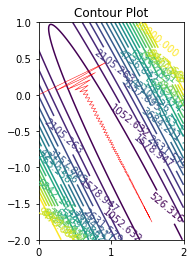

In [103]:
X = iris.data[:,0:2]                              #  regression without intercept
y = iris.data[:,2:3]

def squared_error_linear_contour(beta1, beta2):
    beta = np.array([[beta1], [beta2]])
    return sum((y - X @ beta)**2)

vfunc = np.vectorize(squared_error_linear_contour)

# d1_list = np.linspace(-2, 6, 200)
# d2_list = np.linspace(-6, 2, 200)
d1_list = np.linspace(0, 2, 200)
d2_list = np.linspace(-2, 1, 200)


D1, D2 = np.meshgrid(d1_list, d2_list)
Z = vfunc(D1, D2)

plt.figure()
levels = np.linspace(0, 10000, 20)
ax = plt.subplot()
ax.set_xticks(range(-2,7))
cp = plt.contour(D1, D2, Z, levels = levels)

plt.axis('scaled')
plt.clabel(cp, inline=True, fontsize=10)
plt.plot(temp_beta[0,0:868], temp_beta[1,0:868], "-r", linewidth = 0.5)
plt.title('Contour Plot')
plt.show()


Above contour plot shows the squared error loss function for linear regression, the red trace is given by the backtracking line search, so we can see this shows the "zigzag" nature of the gradient-based methods.

## 2.2 Logistic Regression

Usually, we use maximize the log-likelihood function in logistic (binary) regression, and take the negative, then this becomes cross entropy loss:

\begin{align*}
E[f(x), t] = -t \log{f(x)} - (1-t)\log(1-f(x))
\end{align*}

note here that $t \in \{0,1\}$, which is $\{0,1\}$ coded. If we use the different coding scheme to let $t = (1+y)/2$, so $y$ is $\{-1, +1\}$ coded, then plug in $t = (1+y)/2$ into above formula:

\begin{align*}
E[f(x),y] = -\frac{y+1}{2} \log{f(x)} - \frac{1-y}{2}\log(1-f(x))
\end{align*}
since in logsitic regression, $f(x) = \frac{1}{1+e^{-\omega^T x}}$, so
\begin{align*}
E[f(x),y] &= \frac{y+1}{2} \log(1+e^{-\omega^T x})-\frac{1-y}{2}(-\omega^T x - \log(1+e^{-\omega^T x})) \\
&= \frac{y+1}{2} \log(1+e^{-\omega^T x}) + \frac{1-y}{2} \log(1+e^{-\omega^T x}) + \frac{1-y}{2}\omega^T x  \\
&= \log(1+e^{-\omega^T x}) + \frac{1-y}{2} \omega^T x
\end{align*}
In the above formula  
* Case 1, y =+1, we have $\log(1+e^{-\omega^T x}) = \log(1+e^{-y \omega^T x})$
* Case 2, y =-1, we have $\log(1+e^{-\omega^T x}) + \omega^T x = \log(1+e^{-\omega^T x}) + \log(e^{\omega^T x}) = \log(e^{\omega^T x} + 1) = \log(1+e^{-y \omega^T x})$

In either case, we have loss function, and we call this logistic loss:

\begin{align*}
\log(1+e^{-y \omega^T x})
\end{align*}

In practice, if we have training data with sample size N, we will maximize log-likelihood

\begin{align*}
\frac{1}{N} \sum_{n=1}^{N} \big[t_n \log{f(x_n)} + (1-t_n)\log(1-f(x_n)) \big]
\end{align*}

Now we know this is equivalent to minimize the logistic loss
\begin{align*}
C(\omega) = \frac{1}{N} \sum_{i=1}^{N} \log(1 + e^{-y_n \omega^T x_n})
\end{align*}
Actually, it's not hard to prove this loss is convex using the Hessian matrix, therefore, if we use the gradient-based methods, we can guarantee to find a global minimum.

**Backtracking line search:**

In [104]:
temp_beta = np.zeros([2, 10000])

def logistic_error(X, y, beta):
    xy = np.repeat(y, len(beta), axis=1)*X
    return sum(np.log(1+np.exp(-xy @ beta)))/len(X[:,0])


def logistic(x):
    return 1/(1 + np.exp(-x))

# Gradient of logistic regression of single observation, argument "xy" is a vector:
def grad_logistic_one_obs(xy, beta):
    grad = logistic(- xy @ beta) * (- xy)
    return grad

def grad_logistic(X, y, beta):
    grad_all = np.apply_along_axis(grad_logistic_one_obs, 1, np.repeat(y, len(beta), axis=1)*X, beta)
    return (np.sum(grad_all, axis = 0).reshape(len(beta), 1))/len(X[:,0])
   

# Logistic regression gradient Descent using backtracking:
def grad_desc_logistic_back(X, y, a, b):
    beta = np.array([[-4],[2]])
    for i in times:
        temp_beta[:,i] = beta.reshape(2,)
        grad = grad_logistic(X, y, beta)
        t = 1
        while logistic_error(X, y, beta + t*(-grad)) > logistic_error(X, y, beta)-a*t*np.sum(grad**2):
            t = b*t
#             print(t)
        beta = beta - t*grad
#         print(beta)
        if all(abs(grad_logistic(X, y, beta)) <= 0.001):
            print(i)
            break
    return beta


In [105]:
# Use the first two classes to do logistic regression
# Regression without intercept

X = iris.data[50:, (0,2)]
y = (iris.target[50:] * 2 - 3).reshape(len(X[:,0]),1)

times = range(10000)
print( "The final weight for logistic regression is: ", 
      grad_desc_logistic_back(X = X, y = y, a=0.1, b=0.8) )

3013
The final weight for logistic regression is:  [[-6.0562781 ]
 [ 7.73780806]]


Here we still use iris dataset, but we only use last 100 observations, where we use:

* predictors: Sepal.Length, Petal.Length
* Target: versicolor, virginica

We use the backtracking line search to do logistic regression, since generally it performs better than constant step version

**Logistic Regression Contour Plot:**

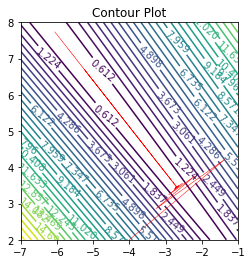

In [106]:
X = iris.data[50:, (0,2)]
y = (iris.target[50:] * 2 - 3).reshape(len(X[:,0]),1)

def logistic_error_contour(beta1, beta2):
    beta = np.array([[beta1], [beta2]])
    xy = np.repeat(y, len(beta), axis=1)*X
    return sum(np.log(1+np.exp(-xy @ beta)))/len(X[:,0])


vfunc = np.vectorize(logistic_error_contour)

d1_list = np.linspace(-7, -1, 500)
d2_list = np.linspace(2, 8, 500)
D1, D2 = np.meshgrid(d1_list, d2_list)
Z = vfunc(D1, D2)

plt.figure()
levels = np.linspace(0, 30, 50)
cp = plt.contour(D1, D2, Z, levels = levels)

plt.axis('scaled')
plt.clabel(cp, inline=True, fontsize=10)
plt.plot(temp_beta[0,0:3013], temp_beta[1,0:3013], "-r", linewidth = 0.5)
plt.title('Contour Plot')
plt.show()

The above shows the contour for logistic regression, we can see that this error function has a flat valley, which makes the convergence very slow, this really illustrates that for some pathological functions, we could have some convergence problem for gradient-based methods.

## 2.3 Explore gradient-based method on different function

**Self-defined function: $1.1 \sqrt{x^2 + y^2} - \sin{\sqrt{x^2+y^2}}$**

If we use plot the 1-dimension version for this function:

\begin{align*}
f(x) = 1.1x - \sin{x}
\end{align*}

If we take the derivative, we know that this function has no stationary point, but it's definitely non-convex. So our self-defined function is actually a 2-dimension version of this function $f$.

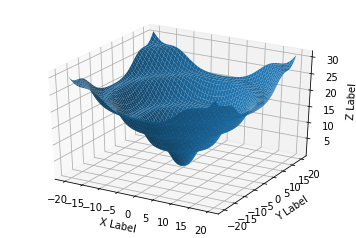

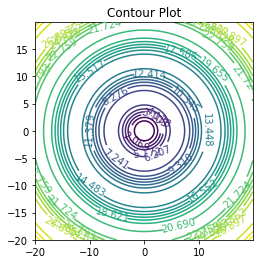

In [107]:
from mpl_toolkits.mplot3d import Axes3D

def wavy(x, y):
    a = 1.1  # a constant greater than 1 to make sure there is no stationary point
    s = 1    # scale parameter controlling the different scale for x and y
    z = a * np.sqrt(x**2 + (s*y)**2) - np.sin(np.sqrt(x**2 + (s*y)**2))
    return z

vwavy = np.vectorize(wavy)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-20.0, 20.0, 0.1)
X, Y = np.meshgrid(x, y)
Z = vwavy(X, Y)


ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

plt.figure()
levels = np.linspace(0, 30, 30)
self_cp = plt.contour(X, Y, Z, levels = levels)

plt.axis('scaled')
plt.clabel(self_cp, inline=True, fontsize=10)
plt.title('Contour Plot')
plt.show()

**Gradient for this function:**

In [109]:
def wavy_grad(x, y):
    if(x == 0 or y == 0):
        return np.zeros((2,1))
    a = 1.1  # A constant greater than 1 to make sure there is no stationary point
    s = 1    # scale parameter controlling the different scale for x and y
    partial_x = a*x*(x**2 + (s*y)**2)**(-0.5) - x*np.cos((x**2 + (s*y)**2)**0.5)*(x**2 + (s*y)**2)**(-0.5)
    partial_y = a*y*(x**2 + y**2)**(-0.5)*s**2 - y*np.cos((x**2 + y**2)**0.5)*(x**2 + y**2)**(-0.5)*s**2
    return np.array([[partial_x], [partial_y]])

# wavy_grad(4.5, 4.5)

**Naive gradient descent for this function:**

In [110]:
times = range(100000)                  # Iteration time, big enough to guarantee convergence
temp_beta = np.zeros([2, 100000])      # record iterations of betas
step_beta = np.zeros([2, 100000])      # record each gradient direction size



# Naive Gradient Descent: use identical step size
def grad_desc_wavy(s):                 # s is the naive gradient descent step size
    beta = np.array([[-50], [-50]])      # Initial starting point
    for i in times:
        temp_beta[:,i] = beta.reshape(2,)
        step_beta[:,i] = (-s*wavy_grad(beta[0].item(), beta[1].item())).reshape(2,)
        beta = beta + (step_beta[:,i]).reshape(2,1)
#         print(i)
        if all(abs(wavy_grad(beta[0].item(), beta[1].item())) <= 0.01):
            print(i)
            break
    return beta

grad_desc_wavy(s = 0.1)


array([[-0.00353598],
       [-0.00353598]])

**Add arrow to steps in contour plot:**

<Figure size 432x288 with 0 Axes>

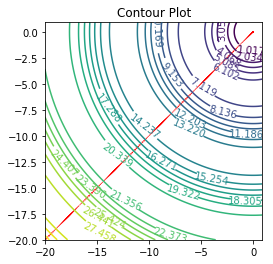

In [30]:
def wavy(x, y):
    a = 1.1  # A constant greater than 1 to make sure there is no stationary point
    s = 1    # scale parameter controlling the different scale for x and y
    z = a * np.sqrt(x**2 + (s*y)**2) - np.sin(np.sqrt(x**2 + (s*y)**2))
    return z

vwavy = np.vectorize(wavy)

fig = plt.figure()
x = np.arange(-20, 1, 0.1)
y = np.arange(-20, 1, 0.1)
X, Y = np.meshgrid(x, y)
Z = vwavy(X, Y)


plt.figure()
levels = np.linspace(0, 60, 60)
self_cp = plt.contour(X, Y, Z, levels = levels)


plt.axis('scaled')
plt.clabel(self_cp, inline=True, fontsize=10)
# plt.plot(temp_beta[0,], temp_beta[1,], "-r", linewidth = 0.5)
plt.quiver(temp_beta[0,:], temp_beta[1,:], 
           step_beta[0,:], step_beta[1,:], 
           angles='xy', scale_units='xy', scale = 1,
           width = 0.005, headwidth = 3, headlength = 3, headaxislength = 3, color = "r")

plt.title('Contour Plot')
plt.show()

plt.show()

From the above contour plot, we can see that when contour level lines are sparse, the update for parameters is pretty slow, and vice verse. This is expected since we are using naive version (constant step) here.

# <h1 align="center">3. Improve Gradient-based Methods on a Pathological Function</h1> 

## 3.1 Analyze the Problem

In [115]:
days = np.array([0,  8,  28,  41,  63,  69, 97, 117,  135,  154])
beetles = np.array([2, 47, 192, 256, 768, 896, 1120, 896, 1184, 1024])

**Squared error function:**

In a previous homework, we need to optimize a squared error function give the above data:

\begin{align*}
\mathcal{E}(K, r) = \sum \Big[X_t - \frac{K N_0}{N_0 + (K - N_0)\exp{-rt}} \Big]^2
\end{align*}

where $t$ is days from data, $X_t$ is beetles from data. For practical meaning, we need to add the constraints that $K>0$, $0<r<1$. We first define this function:

In [116]:
def squared_error(k, r):
    n0 = beetles[0]
    return sum( (beetles - k*n0/(n0 + (k-n0)*np.exp(-r*days)))**2 )

print(squared_error(100,0.1))

4871982.885864232


Next, we define the second partial derivative with respect to $r$ when $K = 1000$, then plot it

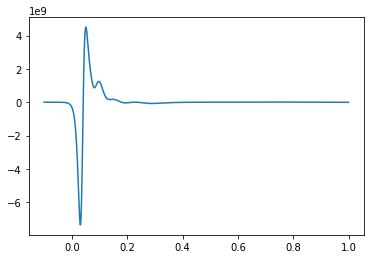

In [117]:
k = 1000
n0 = beetles[0]

def sec_deri(r):
    denom = n0 + (k-n0)*np.exp(-r*days)
    first = days**2 * k*n0*(k-n0)*(beetles*n0-k*n0)*np.exp(-r*days)
    second = 2*days**2 * k*n0*beetles*(k-n0)**2*np.exp(-2*r*days)
    
    third = 3*days*k*n0*(k-n0)*(beetles*n0-k*n0)*np.exp(-r*days)
    fourth = 3*days*k*n0*beetles*(k-n0)**2*np.exp(-2*r*days)
    fifth = (k-n0)*(-days)*np.exp(-r*days)
    
    vec = 2*((first + second)*denom + (third + fourth)*fifth)/denom**4
    return sum(vec)

rr = np.arange(-0.1, 1, 0.001)
func_value = list(map(sec_deri, rr))
plt.plot(rr, func_value)
plt.show()

From the above plot, we can see that, it's neither negative everywhere nor positive everywhere, this means that this bivariate squared error function is non-convex, so it might be the case that there are multiple local minimum.

Next, we define the first derivative of squared error function with respect to $r$ when $K=1000$:

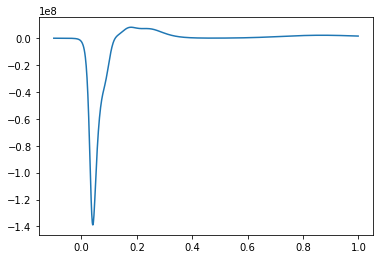

In [118]:
k = 1000
n0 = beetles[0]

def first_deri_r(r):
    denom = n0 + (k-n0)*np.exp(-r*days)
    first = (-days)*k*n0*(k-n0)*(beetles*n0-k*n0)*np.exp(-r*days)
    second = (-days)*k*n0*beetles*(k-n0)**2*np.exp(-2*r*days)
    vec = 2*(first + second)/denom**3
    return sum(vec)

rr = np.arange(-0.1, 1, 0.001)
func_value = list(map(first_deri_r, rr))
plt.plot(rr, func_value)
plt.show()

Above plot only shows a profile of first partial derivative with respect to $r$, we could use bisection method to find the root of it, if the root is unique, then we know this profile function is optimized at that point.

However, it's not easy to show the uniqueness of optimality for entire bivariate function, in the next section we first draw a contour plot

## 3.2 Backtracking Gradient Descent on Beetles Data

**First draw a contour plot:**

/Users/yangziqi/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/yangziqi/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


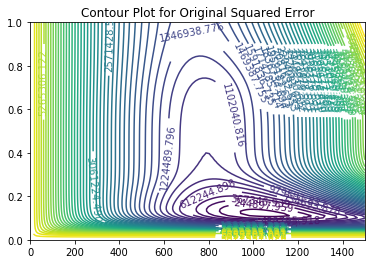

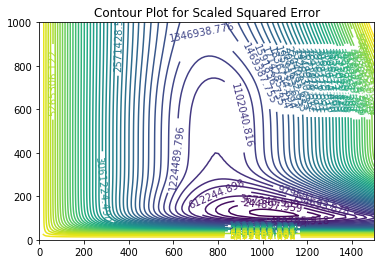

In [128]:
def squared_error(k, r):
    r = r/1000
#     r = r
    n0 = beetles[0]
    return np.sum( (beetles - k*n0/(n0 + (k-n0)*np.exp(-r*days)))**2 )

def squared_error_origin(k, r):
    r = r
    n0 = beetles[0]
    return np.sum( (beetles - k*n0/(n0 + (k-n0)*np.exp(-r*days)))**2 )


v_squared_error = np.vectorize(squared_error)
v_squared_error_origin = np.vectorize(squared_error_origin)


k_list = np.linspace(0, 1500, 100)
r_list = np.linspace(0.0001, 1000, 100)
k_list_origin = np.linspace(0, 1500, 100)
r_list_origin = np.linspace(0, 1, 100)

K, R = np.meshgrid(k_list, r_list)
Z = v_squared_error(K, R)

K_origin, R_origin = np.meshgrid(k_list_origin, r_list_origin)
Z_origin = v_squared_error_origin(K_origin, R_origin)



plt.figure()
levels = np.linspace(0, 6000000, 50)
cp_origin = plt.contour(K_origin, R_origin, Z_origin, levels = levels)
# plt.axis('scaled')
plt.clabel(cp_origin, inline=True, fontsize=10)
# plt.plot(temp_beta[0,0:868], temp_beta[1,0:868], "-r", linewidth = 0.5)
plt.title('Contour Plot for Original Squared Error')
plt.show()



plt.figure()
levels = np.linspace(0, 6000000, 50)
# ax = plt.subplot()
# ax.set_xticks(range(-2,7))
cp = plt.contour(K, R, Z, levels = levels)


# plt.axis('scaled')
plt.clabel(cp, inline=True, fontsize=10)
# plt.plot(temp_beta[0,0:868], temp_beta[1,0:868], "-r", linewidth = 0.5)
plt.title('Contour Plot for Scaled Squared Error')
plt.show()

Above two contour plots show the squared error function under two different parametrization:

* In first plot, we use original error function
* In second plot, we use scaled error function

In the scaled error function, we let the new parameter $r = r/1000$, where the latter $r$ is the old parameter, since we can do a experiment on the original error function using gradient descent, the convergence is excruciatingly slow. 

That's why we operate a linear transformation of parameters to hopefully improve the gradient methods performance. In the meantime, there is also a theory to guarantee that we can perform affine transformations to improve the gradient-based methods, i.e. gradient descent method is not **affine invariant**, this means it is possible improve gradient descent based on affine transformation, and linear transformation is a special case. 

Next, we do the gradient descent using backtracking line search to optimize the squared error function

## Backtracking gradient-descent:

In [131]:
n0 = beetles[0]

def first_deri_k(k, r):
    r = r/1000
    denom = n0 + (k-n0)*np.exp(-r*days)
    first = beetles*denom - k*n0
    second = (1 - np.exp(-r*days))*n0**2
    vec = -2 * first * second/denom**3
    return np.sum(vec)


def first_deri_r(k, r):
    r = r/1000
    denom = n0 + (k-n0)*np.exp(-r*days)
    first = (-days)*k*n0*(k-n0)*(beetles*n0-k*n0)*np.exp(-r*days)
    second = (-days)*k*n0*beetles*(k-n0)**2*np.exp(-2*r*days)
    vec = 2*(first + second)/denom**3
    return np.sum(vec)/1000

times = range(20000)
a = 0.1; b = 0.9
# def grad_desc_beetles_back(a, b):
k = 20             # Initial value for K
r = 900-1         # Initial value for r
for i in times:
    t = 1
    grad_k = first_deri_k(k, r)
    grad_r = first_deri_r(k, r)
    while k+t*(-grad_k) <= 0 or r+t*(-grad_r) <= 0 or r+t*(-grad_r) >= 1000:
        t = b*t
    while squared_error(k+t*(-grad_k), r+t*(-grad_r)) > squared_error(k, r)-a*t*(grad_r**2 + grad_k**2):
        t = b*t
    k = k - t*grad_k
    r = r - t*grad_r
    if abs(first_deri_k(k, r)) <= 0.01 and abs(first_deri_r(k, r)) <= 0.01:
        print(i)
        break
#     print(i)
#     return k, r


# print( "The final result is: ", grad_desc_beetles_back(a = 0.1, b = 0.8) )
print(k, r)

319
1049.4067026567852 118.26841388524102


After we rescale the parameter, we can see that convergence is faster than before, and the algorithm is more stable even when we try different "remote" staring points for $K$ and $r$. So if we want to use first-order methods like backtracking gradient-based method, condition number of the problem is highly important. If we feed this data into R, using function  <code>stats::nls()</code> or  <code>stats::optim()</code>, we can get the same result with us.

# <h1 align="center">4. Conclusion and Further Study</h1> 

We review the basic of gradient-based methods on several problems and see their performance, as we have seen, gradient methods are generally easy to implement, but convergence might be slow in practice.

Due to the time limit, we didn't cover another important topic: MM algorithm, and it's comparison with gradient-based methods, but it's also very important in practice when the direct handling of objective is unwieldy. If time possible, this topic should be added to this project.

# <h1 align="center">5. Reference</h1> 

Boyd, Stephen, and Lieven Vandenberghe. Convex optimization. Cambridge university press, 2004.

Lange, Kenneth. Numerical analysis for statisticians. Springer Science & Business Media, 2010.